# Исследование причины плохой окупаемости развлекательного приложения Procrastinate Pro+.

### Описание проекта.
Мы исследуем расходы на маркетинг развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

Цель исследования :
Выявить причины убытков бизнеса в последние несколько месяцев.

Для достижения цели необходимы выяснить следующее:
откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.




#### Обзор и предобработка данных


Загрузим данные и необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
visits=pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs=pd.read_csv('/datasets/costs_info_short.csv')

Рассмотрим содержимое файлов, проверим содержимое на наличие пропусков, дубликатов и соответствие типов данных в колонках.

In [3]:
visits.info()
print(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01 

In [4]:
orders.info()
print(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99


In [5]:
costs.info()
print(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1


In [6]:
visits['Channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [7]:
costs.Channel.unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [8]:
visits.duplicated().sum()

0

In [9]:
costs.duplicated().sum()

0

In [10]:
orders.duplicated().sum()

0

Пропусков и дубликатов не обнаружено, при этом необходимо привести наименование столбцов к "змеиному регистру", а также изменить форматы столбцов, обозначающих даты.

In [11]:
visits.columns=map(str.lower,visits.columns)
costs.columns=map(str.lower,costs.columns)
orders.columns=map(str.lower,orders.columns)

In [12]:
visits=visits.rename(columns={'session start':'session_start','session end':'session_end','user id':'user_id'})

In [13]:
orders=orders.rename(columns={'user id':'user_id','event dt':'event_dt'})

In [14]:
visits.session_start=pd.to_datetime(visits.session_start)
visits.session_end=pd.to_datetime(visits.session_end)
orders.event_dt=pd.to_datetime(orders.event_dt)
costs.dt=pd.to_datetime(costs.dt).dt.date

#### Вывод

В представленных файлах имелись нарушения стиля, а также несоответствие типов данных в столбцах, обозначающих информацию о датах, данные недостатки исправлены.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Зададим функции для вычисления значения метрик:

In [15]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [16]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Зададим функции для визуализации данных.

In [19]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [20]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(30, 20))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


In [21]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [22]:
def plot_retention(retention, retention_history, horizon,window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # исключаем наложение графиков друг на друга
    plt.tight_layout()

    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### Создание профилей пользователей

Сформируем профили пользователей

In [23]:
events=None
profiles=get_profiles(visits,orders,events,costs)
display(profiles.head())
print('Общее количество полученных профилей:',len(profiles))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Общее количество полученных профилей: 150008


Определим максимальниую и минимальную дату привлечения пользователей исходя из условий задачи

In [24]:
min_date=profiles['dt'].min()
max_date=profiles['dt'].max()
print(min_date)
print(max_date)

2019-05-01
2019-10-27


**Исследование профилей в разрезе стран**

Исследуем профили пользователей в заивисимости от региона и количество платящих пользователей в каждом из регионов.

In [25]:
region_info=profiles.groupby('region')[['user_id','payer']].agg({'user_id':'count','payer':'sum'}).reset_index()
region_info['%_of_payers']=round(region_info['payer']/region_info['user_id']*100,2)
region_info=region_info.sort_values(by='payer',ascending=False)
region_info

,region,user_id,payer,%_of_payers
3,United States,100002,6902,6.90
2,UK,17575,700,3.98
0,France,17450,663,3.80
1,Germany,14981,616,4.11


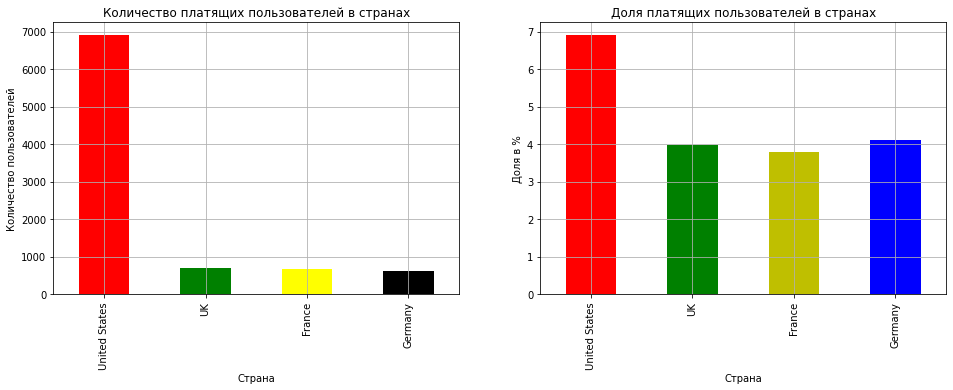

In [26]:
plt.figure(figsize=(16,5))
ax1=plt.subplot(1,2,1)
region_info.plot(kind='bar', x='region',y='payer',grid=True,title='Количество платящих пользователей в странах', ax=ax1,color=['red','green','yellow','black'],legend=None).set(xlabel='Страна',ylabel='Количество пользователей')

ax2=plt.subplot(1,2,2)
region_info.plot(kind='bar', x='region',y='%_of_payers',grid=True,title='Доля платящих пользователей в странах', ax=ax2,color=['r','g','y','b'],legend=None).set(xlabel='Страна',ylabel='Доля в %')
plt.show()

**Вывод**

В приложение приходят пользователи из следующих стран: США, Великобритания, Франция, Германия.
Наибольшее количество платящих пользователей из США, на них приходится более 2/3 всех пользователей, оставшееся количество платящих пользователей равномерно распределено между другими странами. Также в США наибольшая доля платящих пользователей 6,9%, что более чем в 1,5 раза больше, чем в каждом из других регионов

**Исследование пользователей в разрезе устройств**

Исследуем профили пользователей в заивисимости от устройств и количество платящих пользователей каждого устройства.

In [27]:
device_info=profiles.groupby('device')[['user_id','payer']].agg({'user_id':'count','payer':'sum'}).reset_index()
device_info['%_of_payers']=round(device_info['payer']/device_info['user_id']*100,2)
device_info=device_info.sort_values(by='payer',ascending=False)
device_info

,device,user_id,payer,%_of_payers
3,iPhone,54479,3382,6.21
0,Android,35032,2050,5.85
1,Mac,30042,1912,6.36
2,PC,30455,1537,5.05


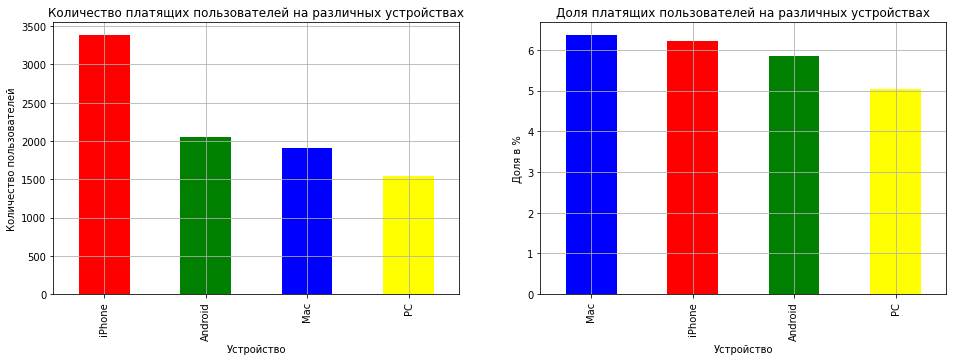

In [28]:
plt.figure(figsize=(16,5))
ax1=plt.subplot(1,2,1)
device_info.plot(kind='bar', x='device',y='payer',grid=True,title='Количество платящих пользователей на различных устройствах', ax=ax1,color=["red", "green", "blue", "yellow"],legend=None).set(xlabel='Устройство',ylabel='Количество пользователей')

ax2=plt.subplot(1,2,2)
device_info.sort_values(by='%_of_payers',ascending=False).plot(kind='bar', x='device',y='%_of_payers',grid=True,title='Доля платящих пользователей на различных устройствах', ax=ax2,color=["blue", "red", "green", "yellow"],legend=None).set(xlabel='Устройство',ylabel='Доля в %')
plt.show()

**Вывод**


Пользователи приложения предпочитают следующие устройства: Айфон, Мак, Андроид, ПК.
При этом наибольшее количество платящих пользователей предпочитают Айфон - 3382 человека.
Наибольшая доля платящих пользователе приходится на Мак - 6,36%, однако отличие от других устройств незначительое.

**Исследование профилей в разрезе источников привлечения**

Исследуем профили пользователей в зависимости от канала привлечения и количество платящих пользователей каждого канала.

In [29]:
channel_info=profiles.groupby('channel')[['user_id','payer']].agg({'user_id':'count','payer':'sum'}).reset_index()
channel_info['%_of_payers']=round(channel_info['payer']/channel_info['user_id']*100,2)
channel_info=channel_info.sort_values(by='%_of_payers',ascending=False)
channel_info

,channel,user_id,payer,%_of_payers
1,FaceBoom,29144,3557,12.20
0,AdNonSense,3880,440,11.34
9,lambdaMediaAds,2149,225,10.47
6,TipTop,19561,1878,9.60
5,RocketSuperAds,4448,352,7.91
7,WahooNetBanner,8553,453,5.30
8,YRabbit,4312,165,3.83
3,MediaTornado,4364,156,3.57
2,LeapBob,8553,262,3.06
4,OppleCreativeMedia,8605,233,2.71


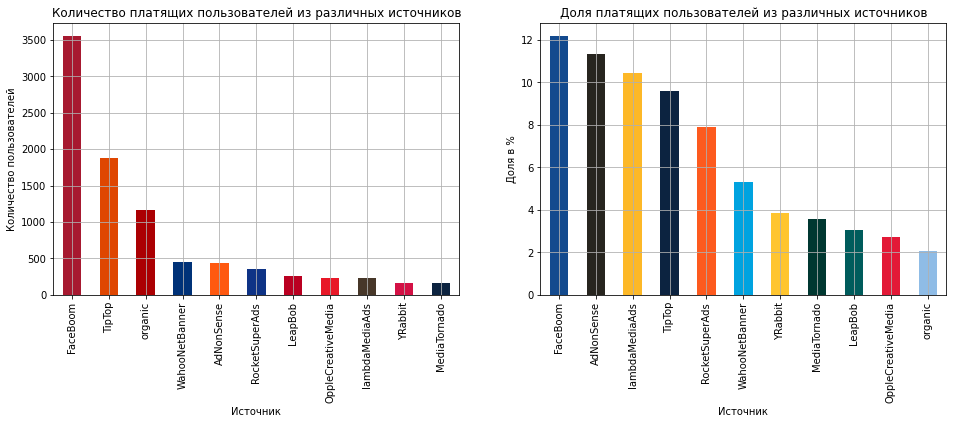

In [30]:
plt.figure(figsize=(16,5))
ax1=plt.subplot(1,2,1)
channel_info.sort_values(by='payer',ascending=False).plot(kind='bar', x='channel',y='payer',grid=True,title='Количество платящих пользователей из различных источников', ax=ax1,color=['#A71930', '#DF4601', '#AB0003', '#003278', '#FF5910', '#0E3386', '#BA0021', '#E81828', '#473729', '#D31145', '#0C2340'],legend=None).set(xlabel='Источник',ylabel='Количество пользователей')

ax2=plt.subplot(1,2,2)
channel_info.sort_values(by='%_of_payers',ascending=False).plot(kind='bar', x='channel',y='%_of_payers',grid=True,title='Доля платящих пользователей из различных источников', ax=ax2,color=['#134A8E', '#27251F', '#FDB827', '#0C2340', '#FD5A1E', '#00A3E0', '#ffc52f', '#003831', '#005C5C', '#E31937', '#8FBCE6'],legend=None).set(xlabel='Источник',ylabel='Доля в %')
plt.show()

**Вывод**

Наибольшее число пользоваетелей приходят в приложение самостоятельно(канал - organic) - 56 тыс. человек, однако доля платящих пользователей органического траффика самое маленькое из всех каналов привлечения - 2,06%
Больше всего платящих пользователей привлекают каналы FaceBoom и TipTop 3557 и 1878 человек соответственно.
Рассматривая долю платящих пользователей, можно также выделить крупные источники FaceBoom и TipTop с долями 12,2% и 9,6 % соответственно, также высокой долей платящих пользователей обладают два малоиспользуемых источника - AdNonSence и lambdaMediaAds 11,34% и 10,47% соответственно.

#### Общий вывод по разделу


В приложение приходят пользователи из следующих стран: США, Великобритания, Франция, Германия.<br>
Наибольшее количество платящих пользователей из США, на них приходится более 2/3 всех пользователей, оставшееся количество платящих пользователей равномерно распределено между другими странами. Также в США наибольшая доля платящих пользователей 6,9%, что более чем в 1,5 раза больше, чем в каждом из других регионов.<br>
Пользователи приложения предпочитают следующие устройства: Айфон, Мак, Андроид, ПК.<br>
При этом наибольшее количество платящих пользователей предпочитают Айфон - 3382 человека.<br>
Наибольшая доля платящих пользователе приходится на Мак - 6,36%, однако отличие от других устройств незначительое.<br>
Наибольшее число пользоваетелей приходят в приложение самостоятельно(канал - organic) - 56 тыс. человек, однако доля платящих пользователей органического траффика самое маленькое из всех каналов привлечения - 2,06%<br>
Больше всего платящих пользователей привлекают каналы FaceBoom и TipTop 3557 и 1878 человек соответственно.<br>
Рассматривая долю платящих пользователей, можно также выделить крупные источники FaceBoom и TipTop с долями 12,2% и 9,6 % соответственно, также высокой долей платящих пользователей обладают два малоиспользуемых источника - AdNonSence и lambdaMediaAds 11,34% и 10,47% соответственно.<br>

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

Расчитаем общую сумму расходов на маркетинг

In [31]:
print('Общая сумма расходов на маркетинг:', round(int(costs['costs'].sum()),2))

Общая сумма расходов на маркетинг: 105497


Рассчитаем распределение расходов на каждый источник

In [32]:
channel_costs=costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs',ascending=False)
channel_costs['%_of_costs']=round(channel_costs['costs']/channel_costs['costs'].sum()*100,2)
channel_costs

,costs,%_of_costs
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


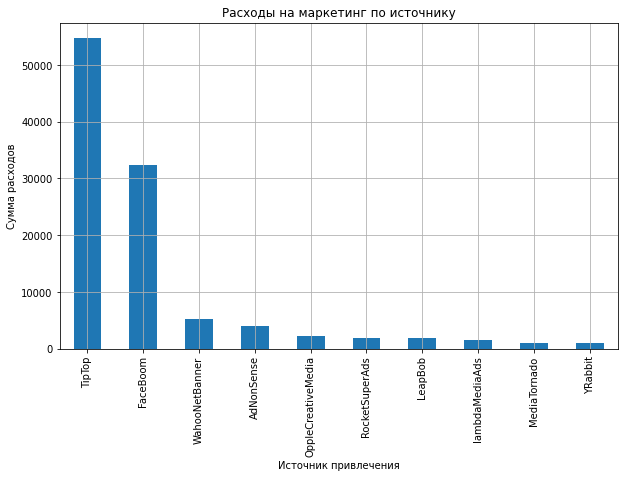

In [33]:
channel_costs.plot(kind='bar',grid=True,y='costs',title='Расходы на маркетинг по источнику',figsize=(10,6),legend=None).set(ylabel='Сумма расходов',xlabel='Источник привлечения')
plt.show()

Общая сумма затрат на рекламу составляет 105497 долларов, при этом основная доля расходов приходится на два канала TipTop - 51.9% и FaceBoom 30.75%

In [34]:
costs['month']=costs['dt'].astype('datetime64[M]')
costs['week']=costs['dt'].astype('datetime64[W]')

In [35]:
month_costs=costs.pivot_table(index='month',columns='channel',values='costs',aggfunc='sum')

In [36]:
week_costs=costs.pivot_table(index='week',columns='channel',values='costs',aggfunc='sum')


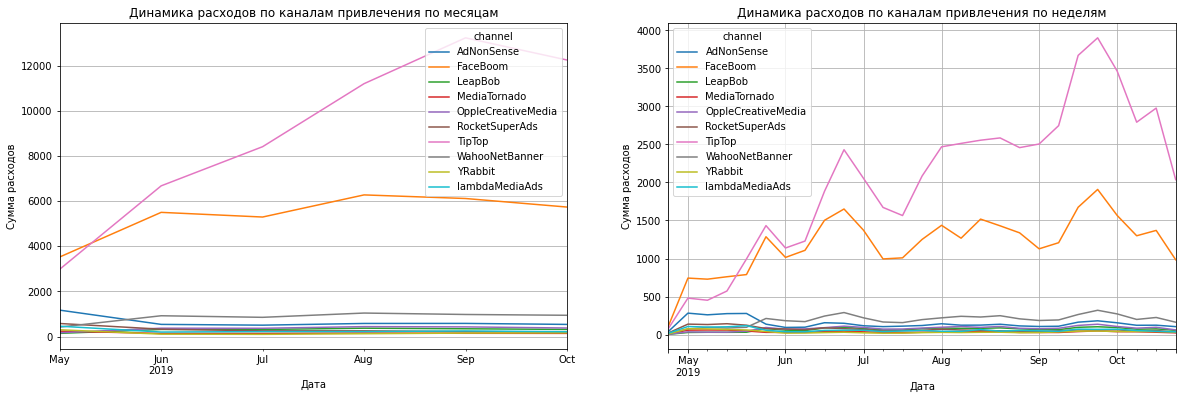

In [37]:
plt.figure(figsize = (20, 6))   


month_costs.plot(title='Динамика расходов по каналам привлечения по месяцам',grid=True,ax=plt.subplot(1,2,1)).set(xlabel='Дата',ylabel='Сумма расходов')


week_costs.plot(title='Динамика расходов по каналам привлечения по неделям',grid=True,ax=plt.subplot(1,2,2)).set(xlabel='Дата',ylabel='Сумма расходов',)
plt.show()

В динамике также прослеживается постоянный рост расходов на два канала TipTop и FaceBoom, при этом расходы на все остальные каналы являются постоянными и значительно отличаются в меньшую сторону.

Расчитаем стоимость привлечения одного покупателя для каждого канала, для этого исключим из данных канал привлечения organic.

In [38]:
print('Средний САС по всем пользователям платных каналов:', round(profiles.query('channel != "organic"')['acquisition_cost'].mean(), 2))

Средний САС по всем пользователям платных каналов: 1.13


In [39]:
CAC=round(profiles.query('channel !="organic"').groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost',ascending=False),2)
CAC


,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самыми дорогими каналами привлечения являются TipTop - 2,8 доллара за каждого нового пользователя и FaceBoom - 1,11 доллара за каждого пользователя. 

**Вывод**


Общая сумма затрат на рекламу составляет 105497 долларов, при этом основная доля расходов приходится на два канала TipTop - 51.9% и FaceBoom 30.75%
В динамике также прослеживается постоянный рост расходов на два канала TipTop и FaceBoom, при этом расходы на все остальные каналы являются постоянными и значительно отличаются в меньшую сторону.
Самыми дорогими каналами привлечения являются TipTop - 2,8 доллара за каждого нового пользователя и FaceBoom - 1,11 доллара за каждого пользователя. 


### Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Общая окупаемость рекламы

Исходя из условия, анализ данных осуществляется 1.11.2019 года, при этом пользователя должны окупаться не позднее чем через 2 недели. Обозначим момент и горизонт наблюдения.

In [40]:
observation_date=datetime(2019,11,1).date()
horizon_date=14

Для исследования необходимо исключить из анализа пользователей, которые самостоятельно нашли приложение.

In [41]:
profiles=profiles.query('channel!="organic"')

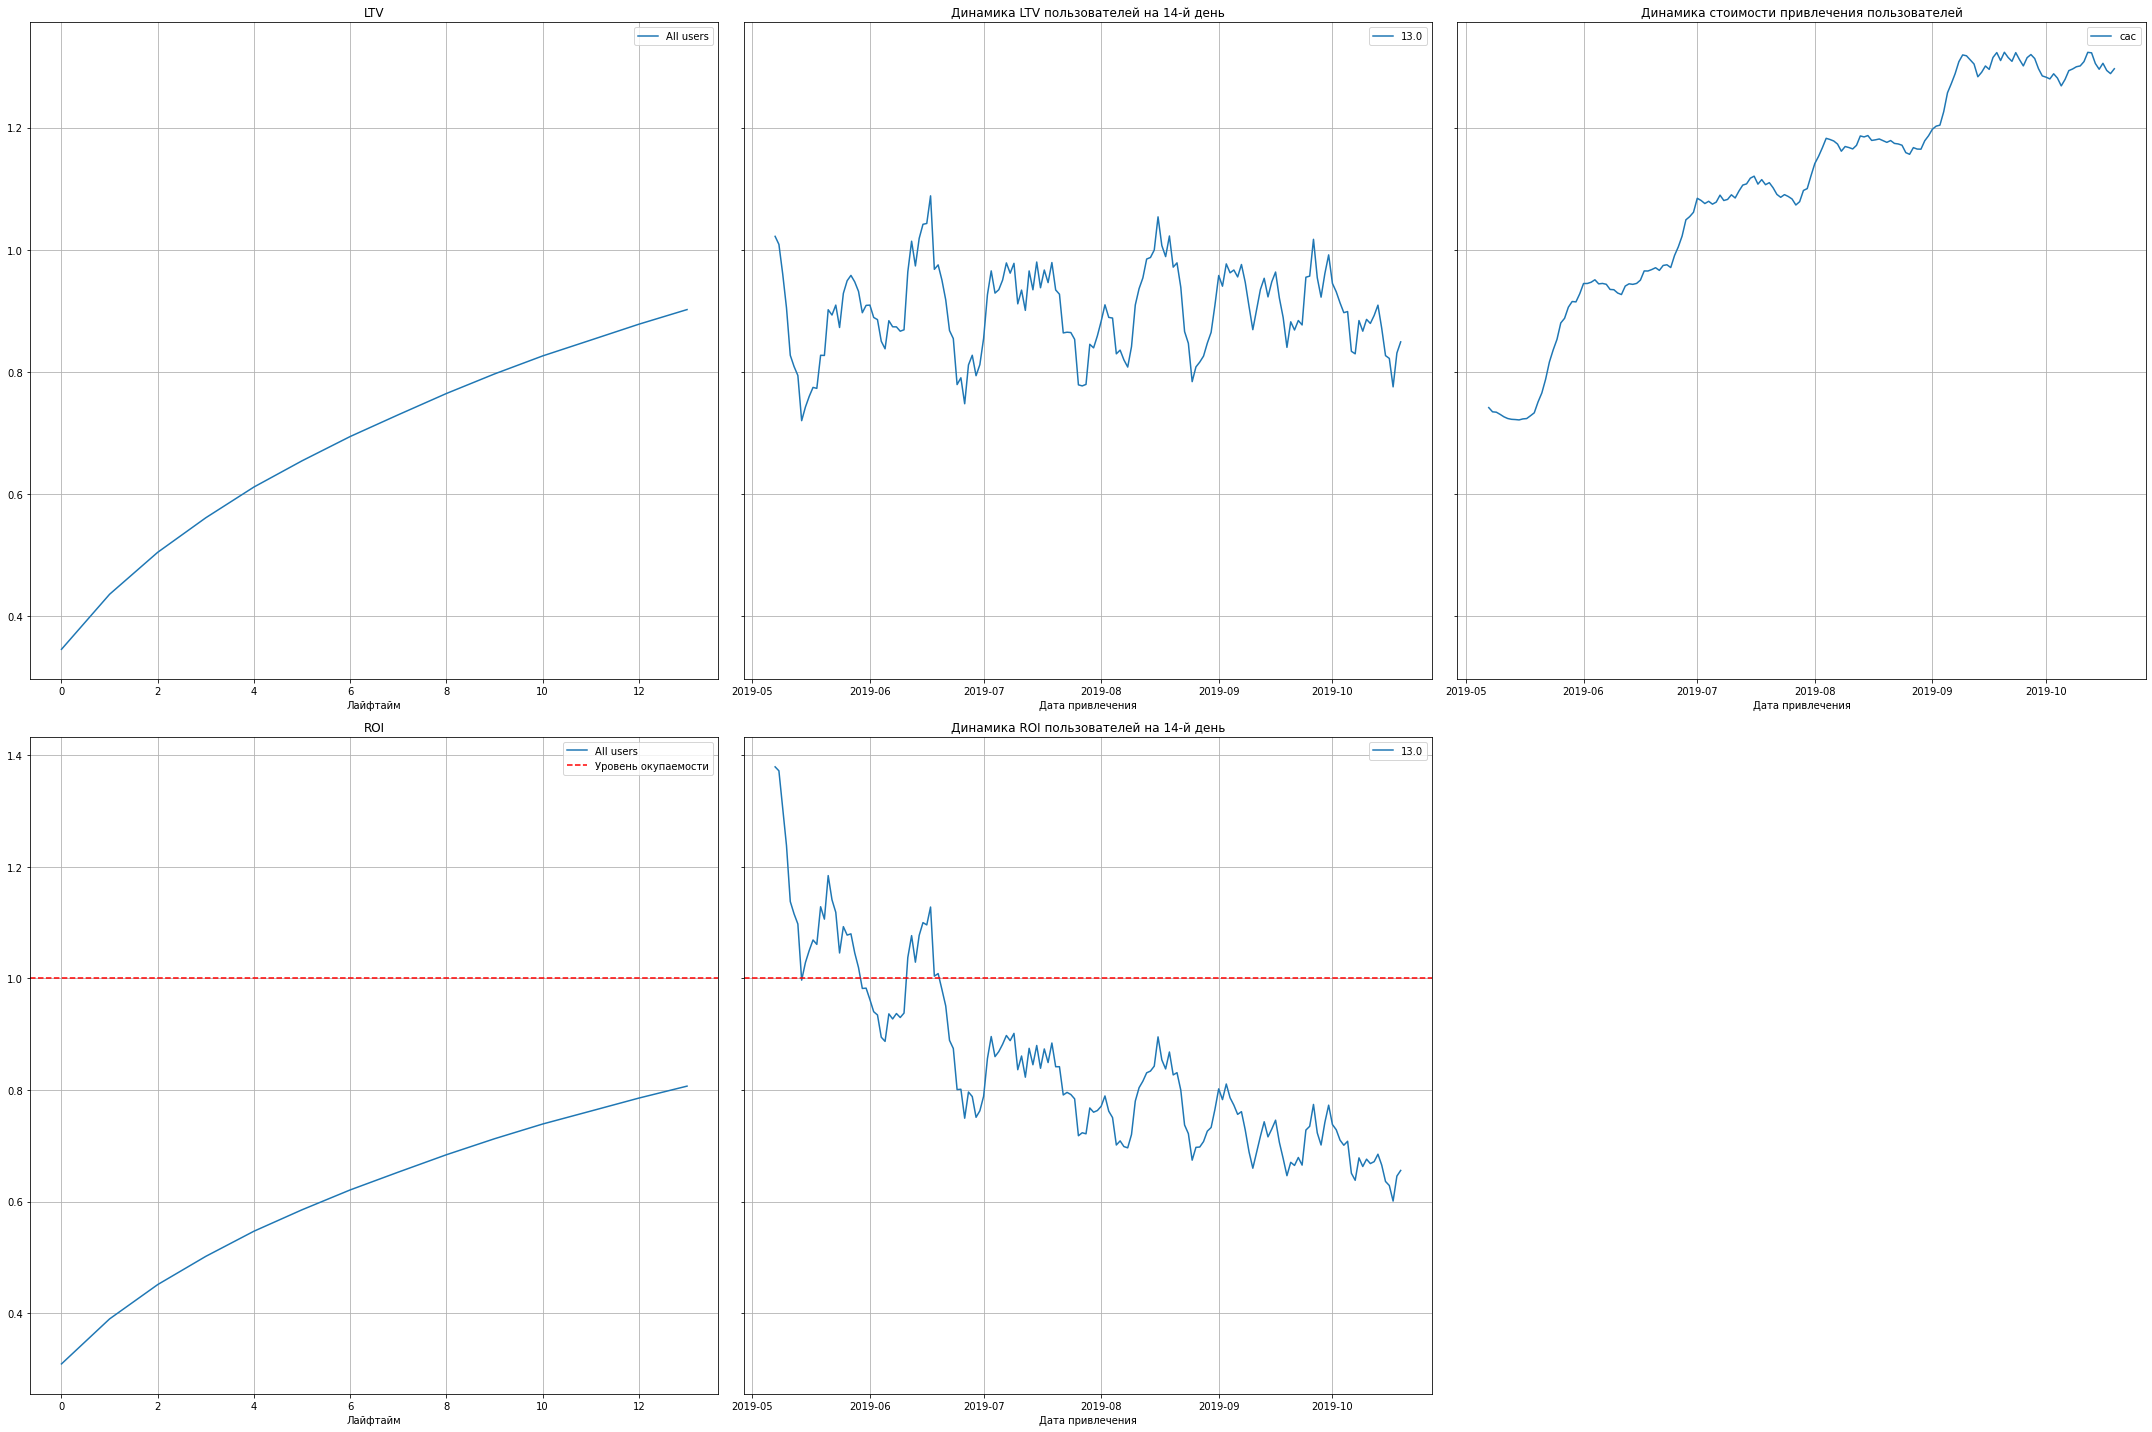

In [42]:
ltv_raw,ltv_grouped,ltv_history,roi_grouped,roi_history=get_ltv(profiles,orders,observation_date,horizon_date)
plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,horizon_date)

Исходя из анализа общих графиков, можно обозначить имеющуюся проблему: при относительно стабильном уровне LTV, на постоянной основе происходит увеличение расходов по привлечению пользователей(САС), что и привело к тому, что уровень окупаемости с середины июня опустился ниже предельного уровня, и общий уровень окупаемости рекламы доходит лишь до 80% 

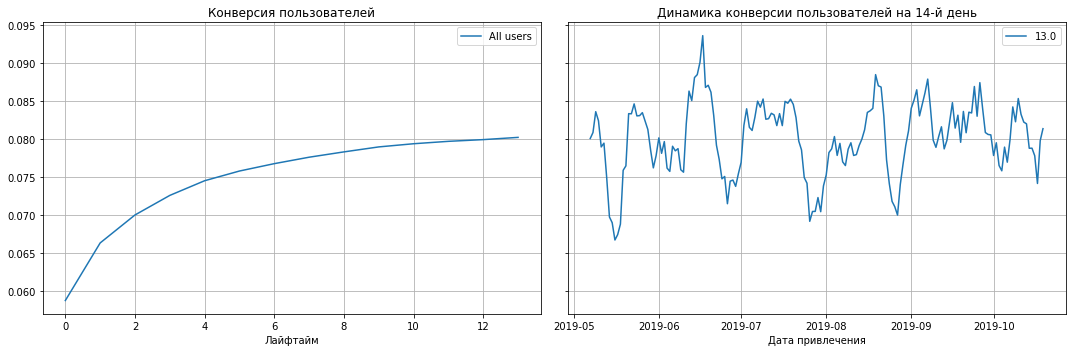

In [43]:
conversion_raw,conversion_grouped,conversion_history=get_conversion(profiles,orders,observation_date,horizon_date)
plot_conversion(conversion_grouped,conversion_history,horizon_date)

Общая конверсия всех пользователей по истечению 14 дней составляет 8%, при этом динамика конверсии относительно стабильная.

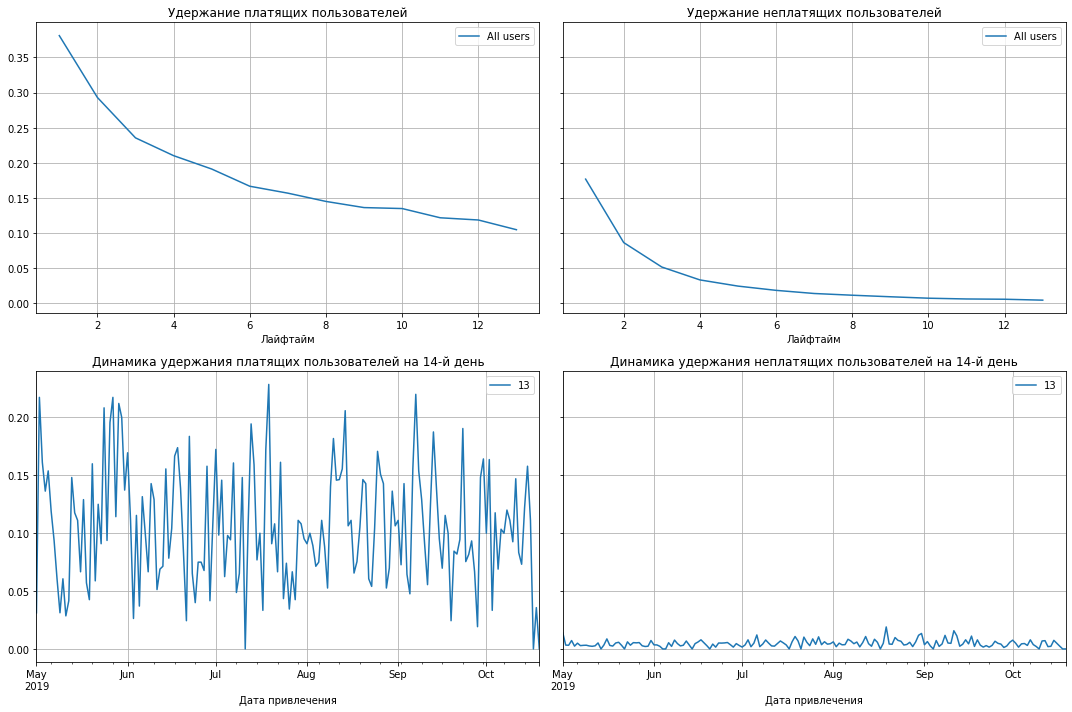

In [44]:
retention_raw, retention,retention_history = get_retention(profiles, visits, observation_date, horizon_date)
plot_retention(retention, retention_history, horizon_date)


Удержание пользователей к концу лайфтайма составляет примерно 10%, динамика также относительно стабильная.

#### Окупаемость рекламы с в разрезе устройств

Исследуем окупаемость рекламы с разбивкой по устройствам.

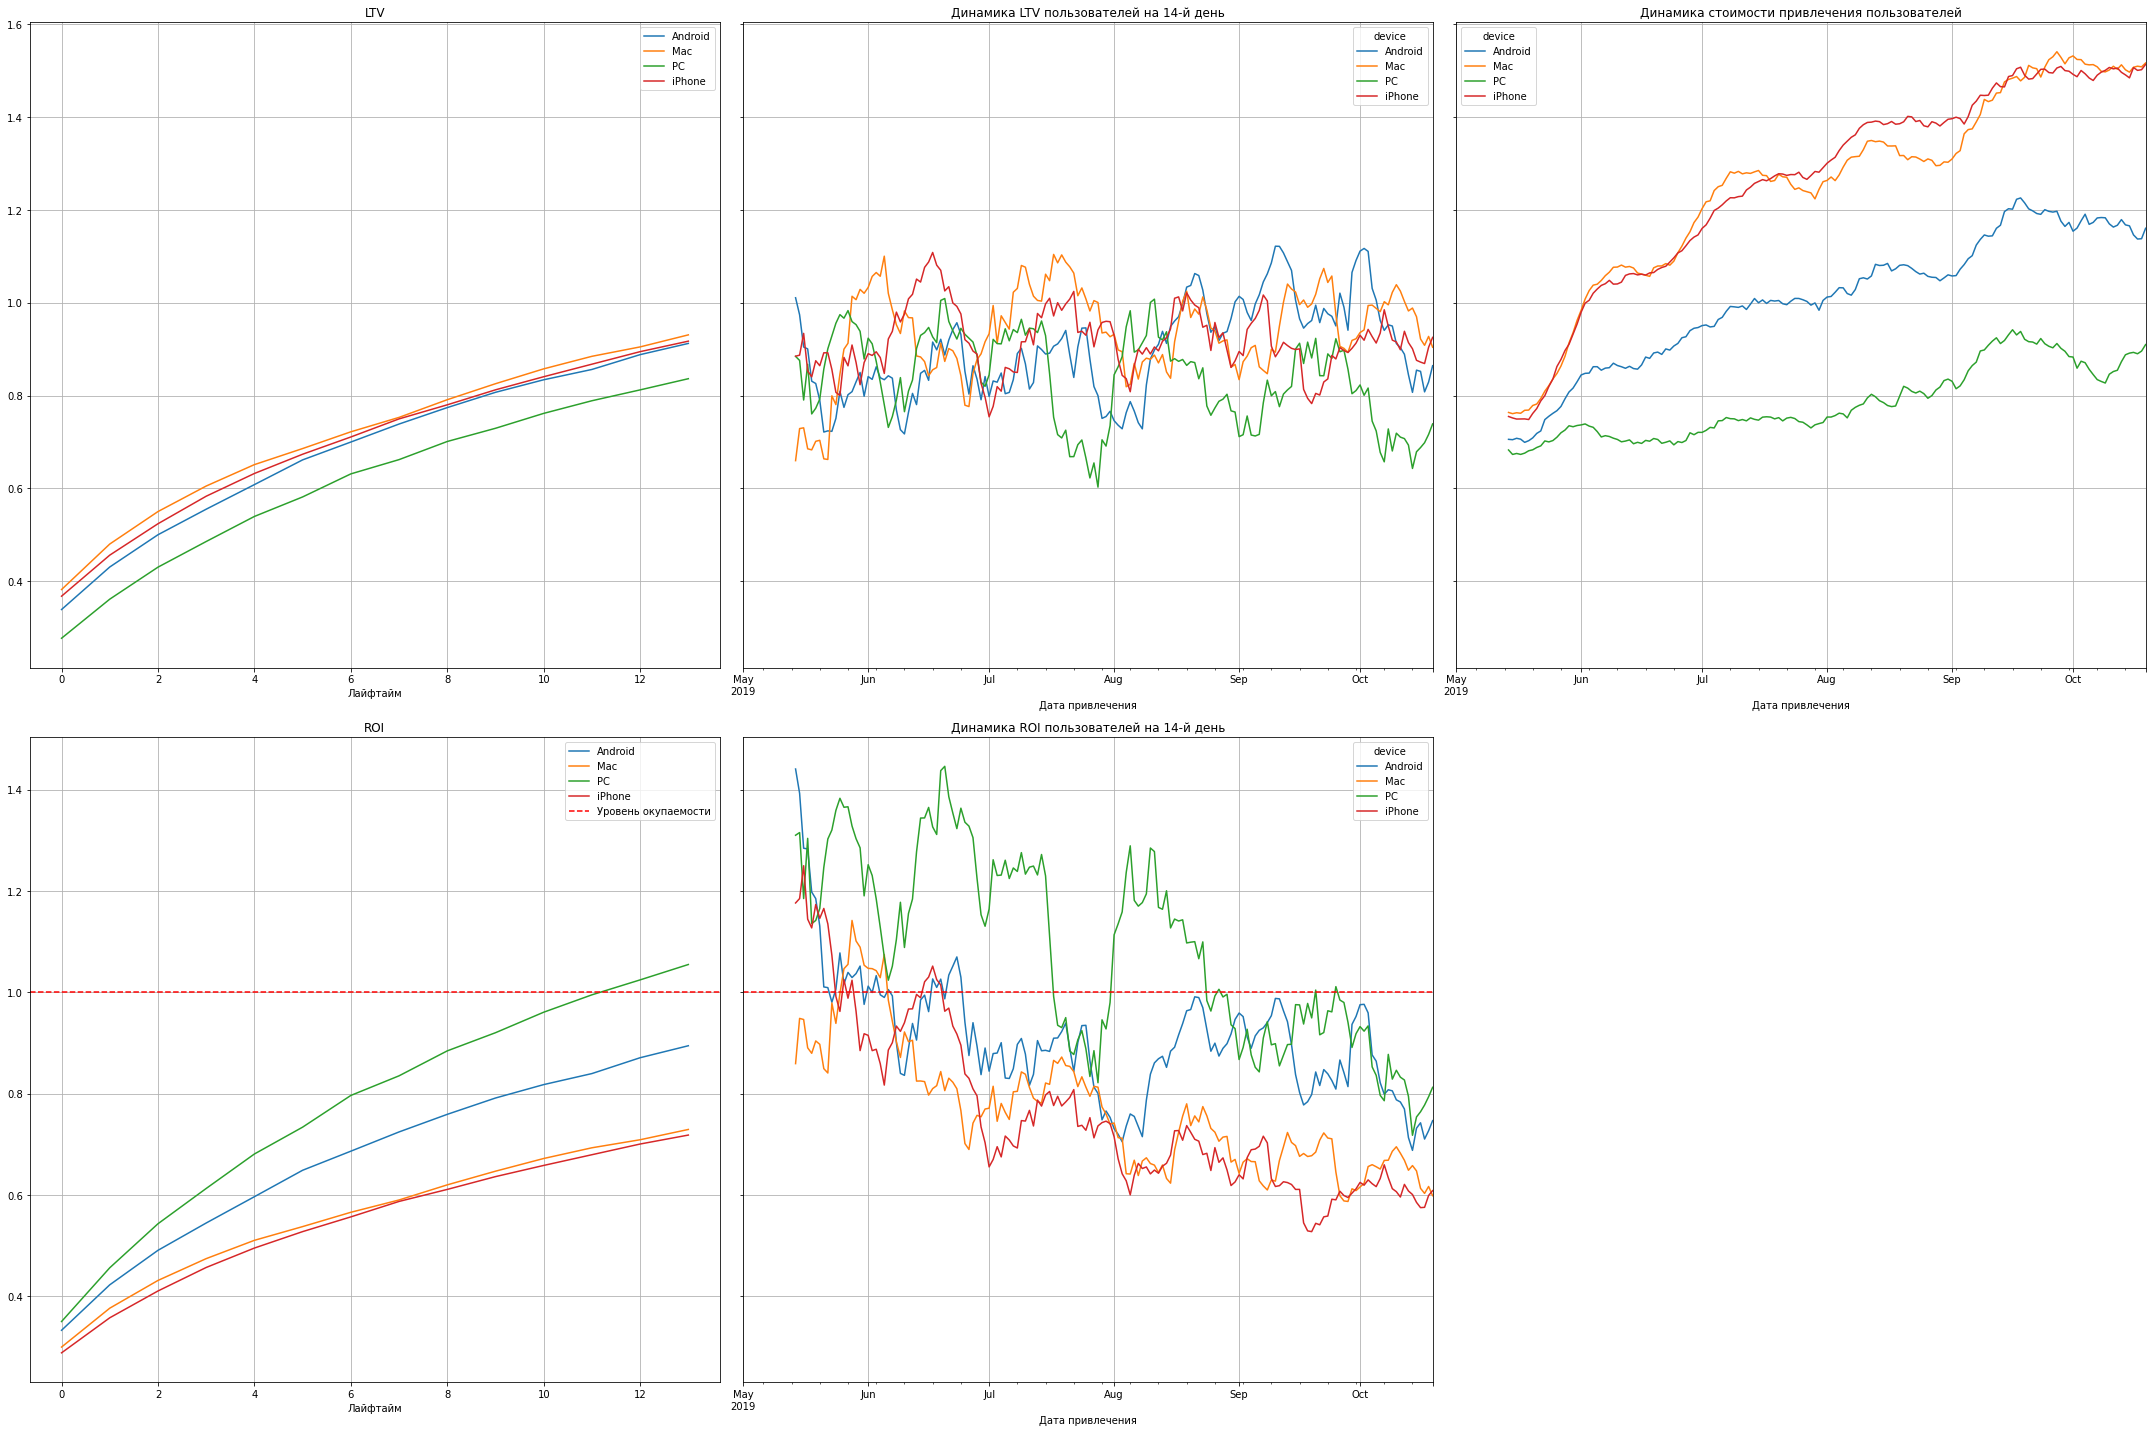

In [45]:

ltv_raw,ltv_grouped,ltv_history,roi_grouped,roi_history=get_ltv(profiles,orders,observation_date,horizon_date,dimensions=['device'])
plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,horizon_date,window=14)

Все кроме устройств ПК не окупаются, при этом динамика ROI на постоянной основе уменьшается, а динамика стоимости привлечения увеличивается. Самыми "дорогими" устройствами являются пользователи Айфона и Мак.

#### Окупаемость рекламы в разрезе стран

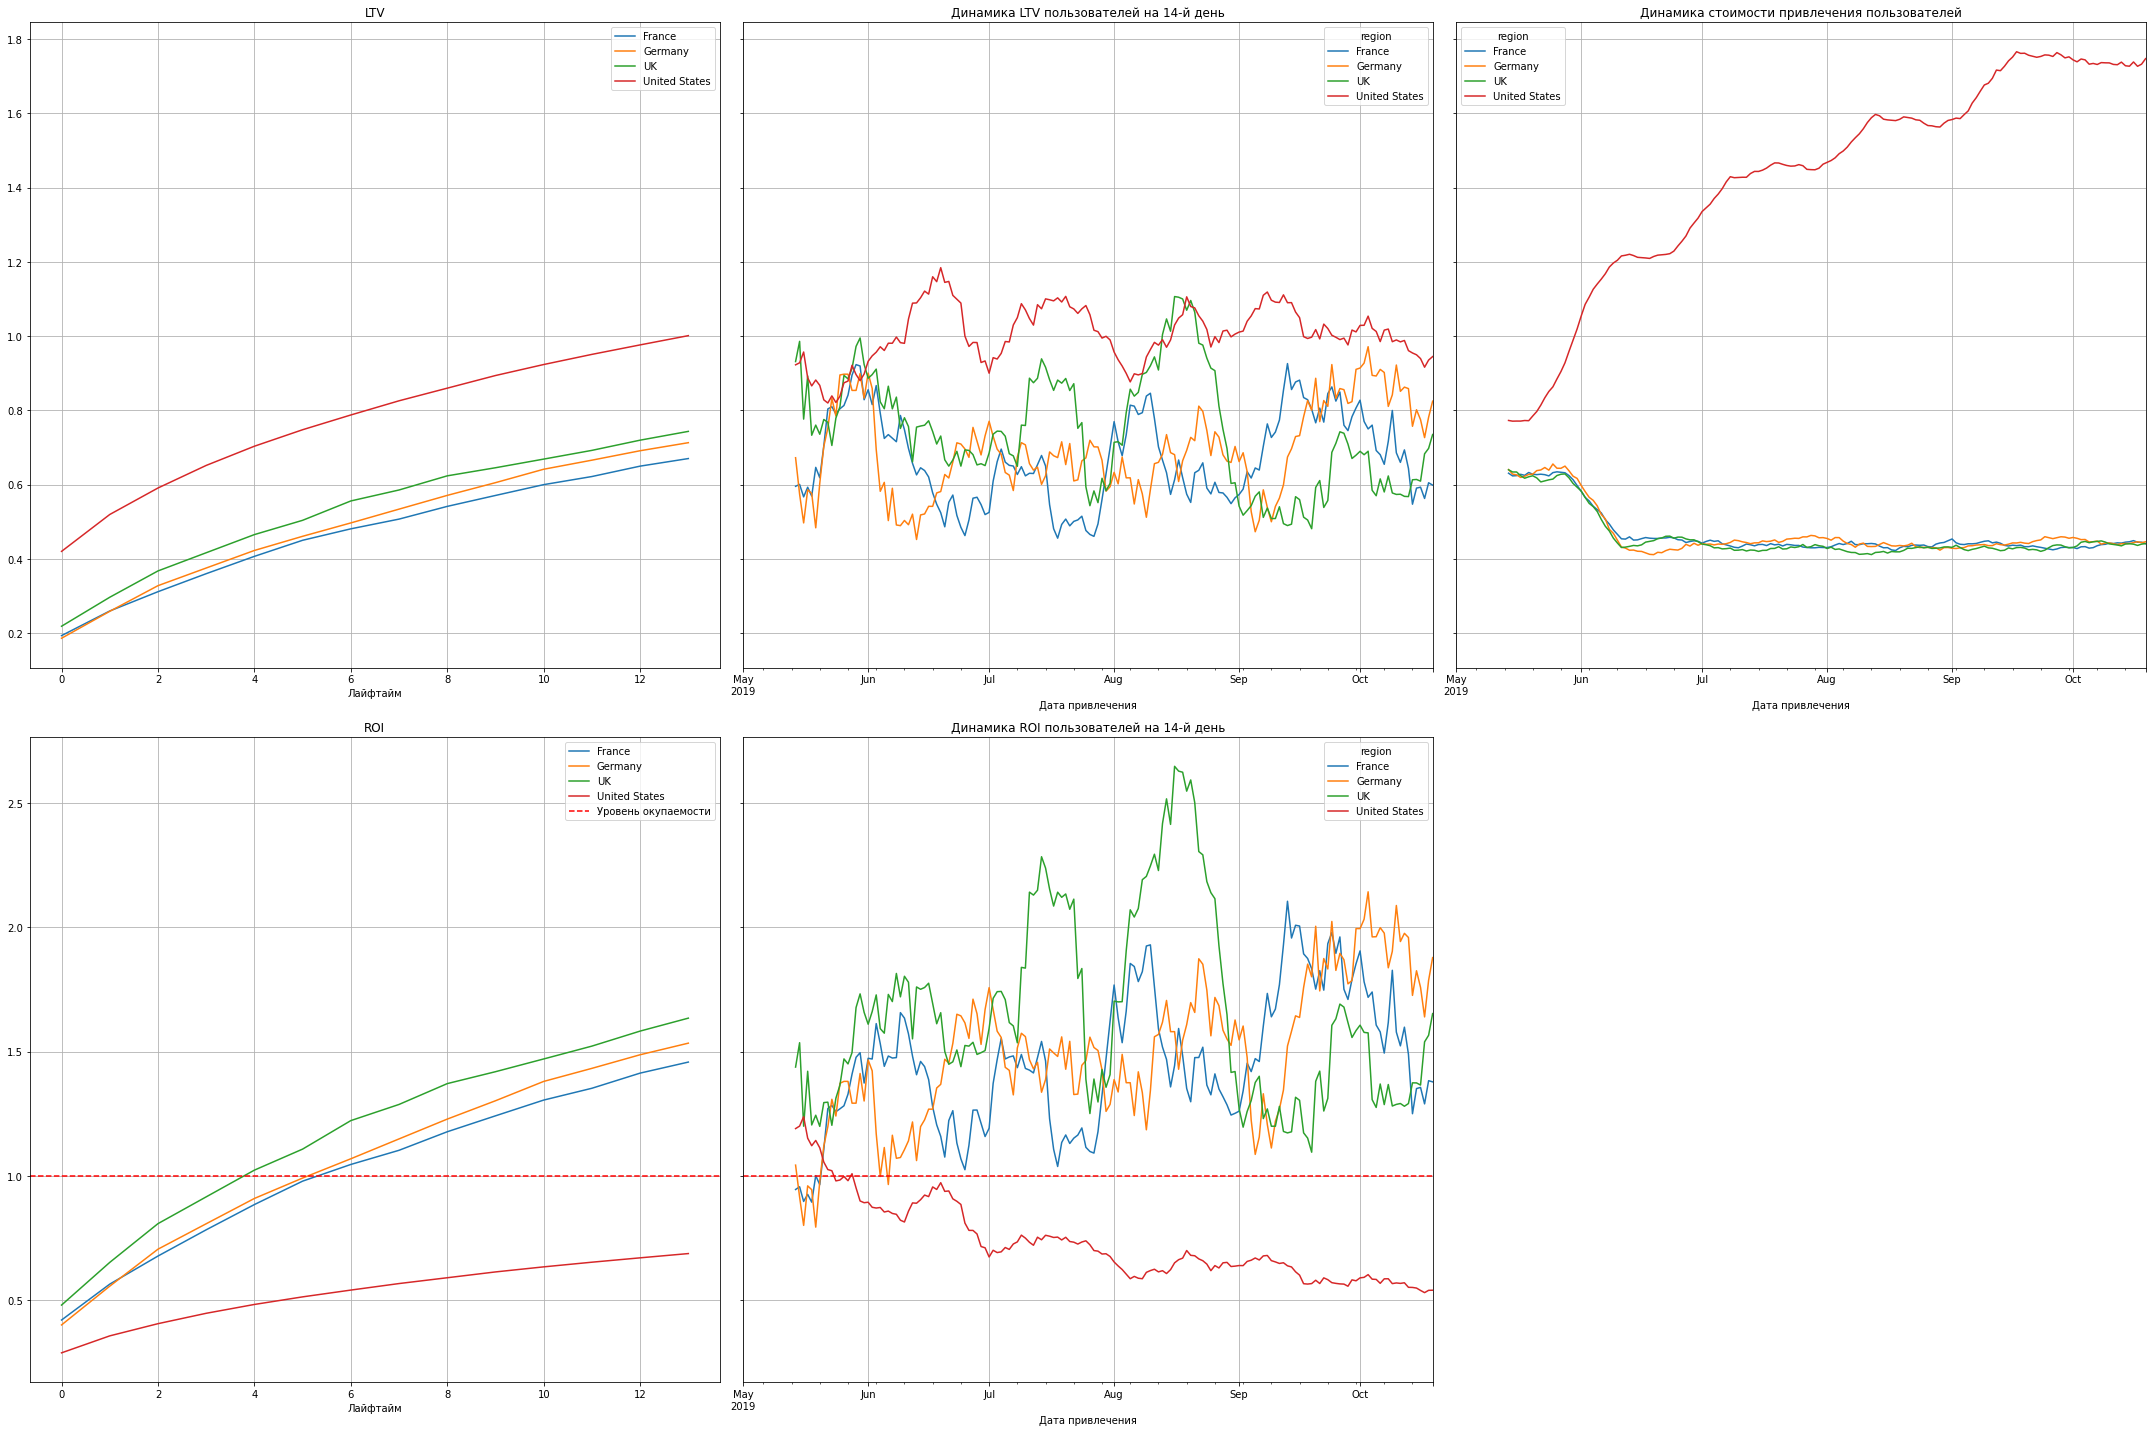

In [46]:

ltv_raw,ltv_grouped,ltv_history,roi_grouped,roi_history=get_ltv(profiles,orders,observation_date,horizon_date,dimensions=['region'])
plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,horizon_date,window=14)

Исходя из графиков, пользователи США значительно отличаются от пользователей других стран.
Так, у данных пользователей самый большой LTV, но при этом самая высокая стоимость привлечения пользователей.
Также пользователи США являются единственной когортой, которая не окупается. Уровень окупаемости достигает лишь 60-70%.
Учитывая то, что пользователей из США больше всех, полученные данные могут являться обоснованием текущих проблем компании.

#### Окупаемость рекламы в разрезе каналов привлечения пользователей

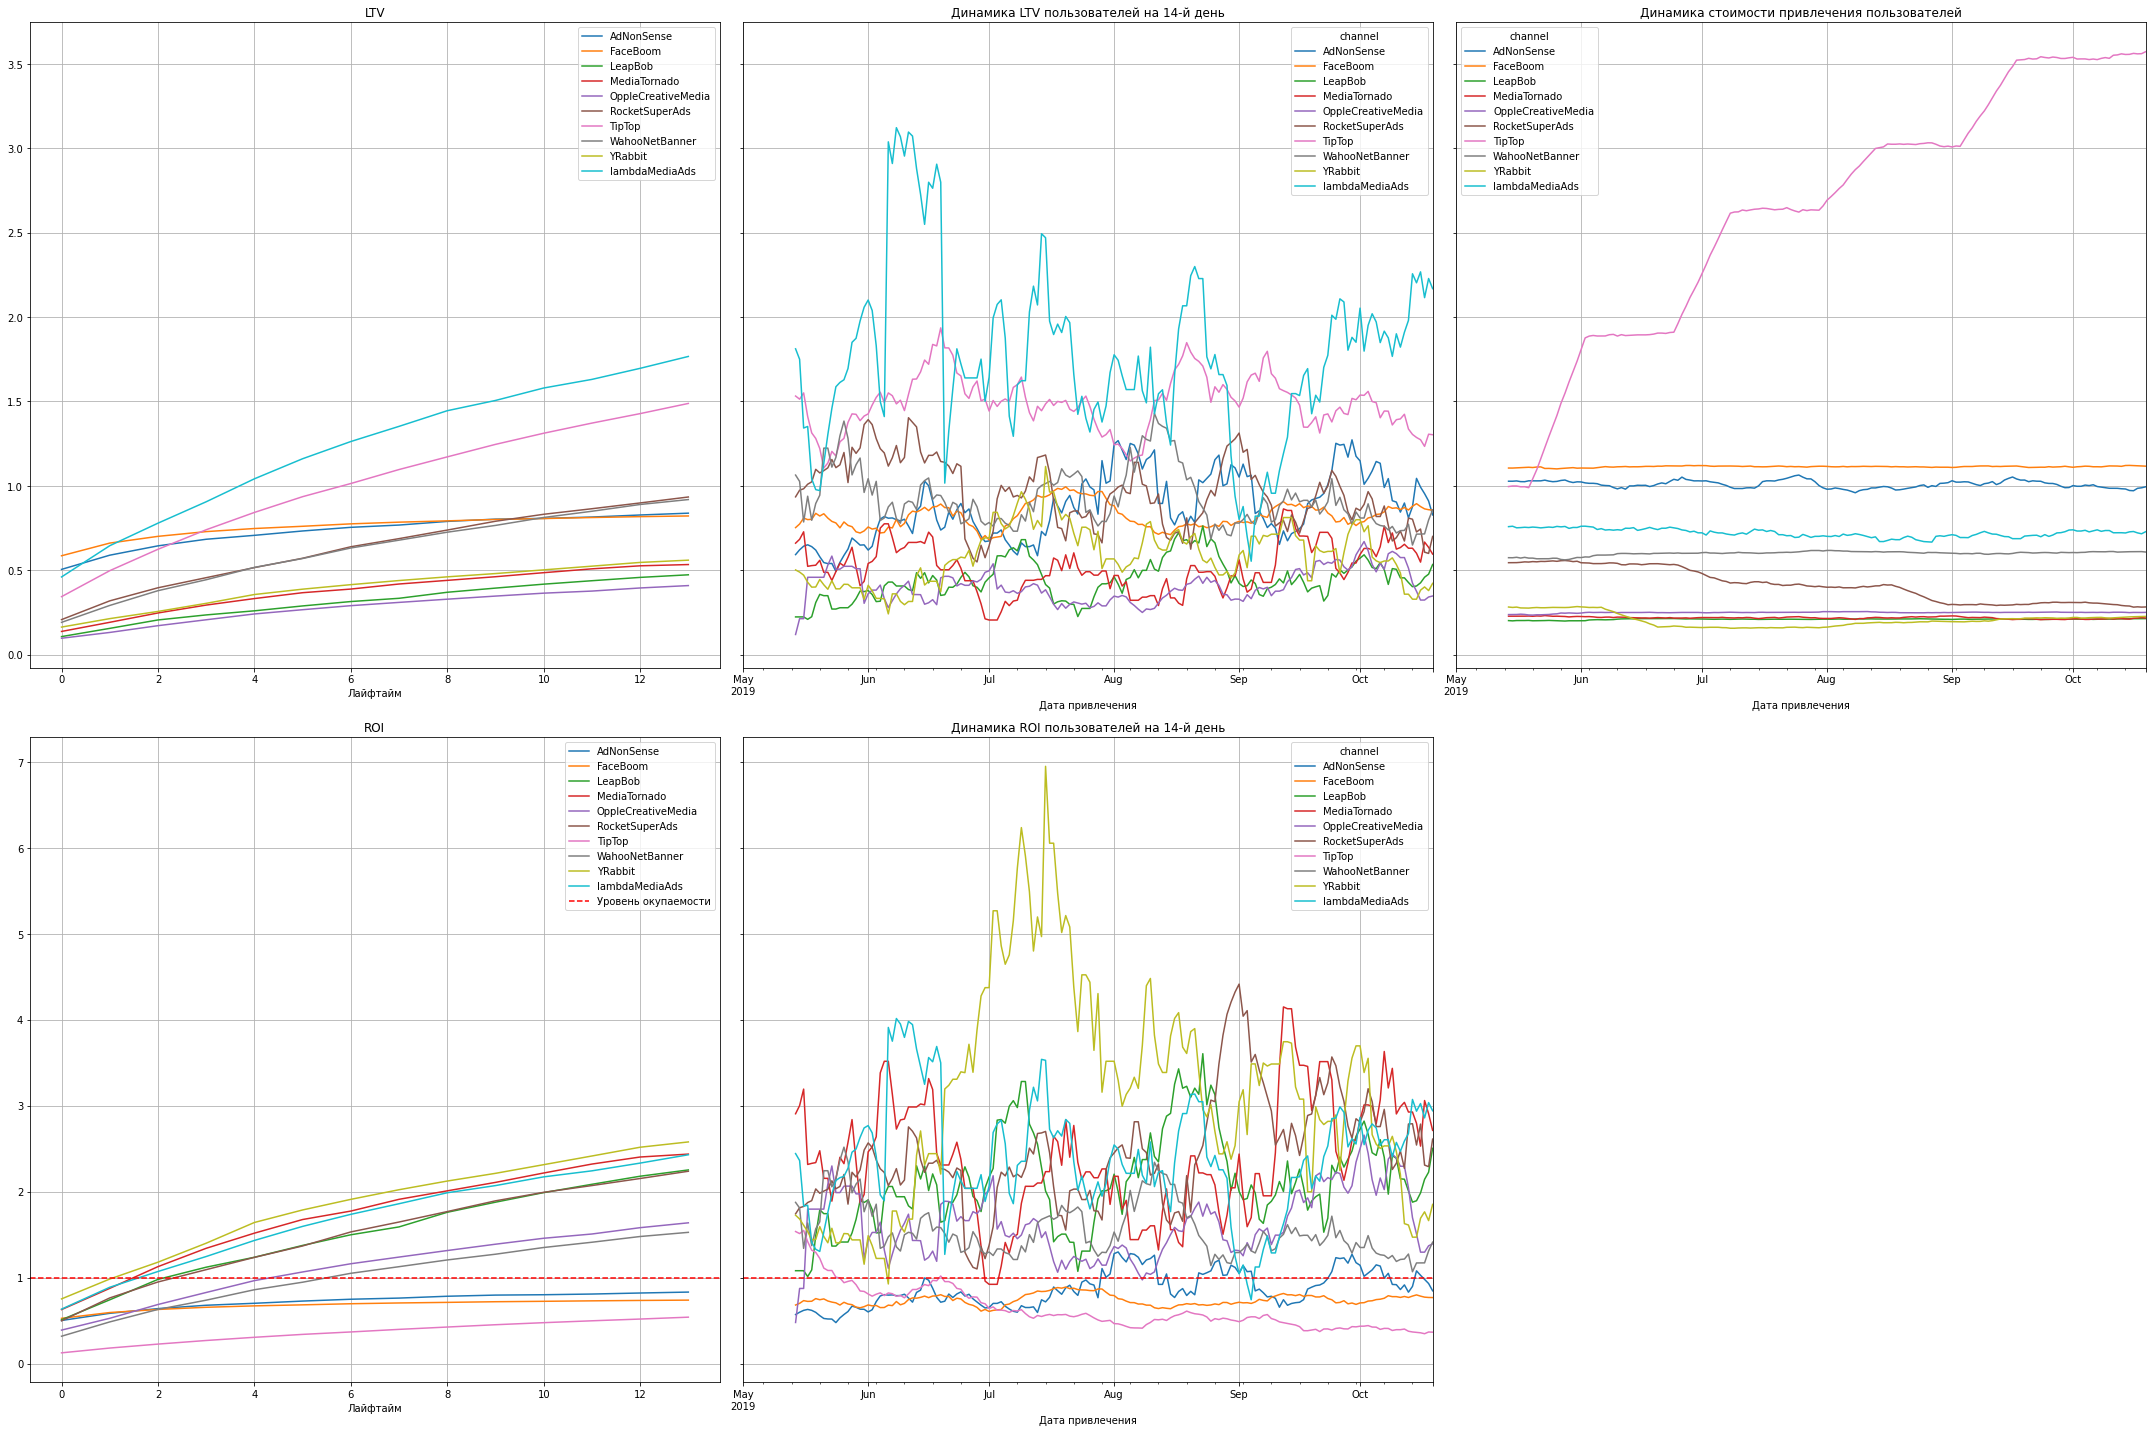

In [47]:
ltv_raw,ltv_grouped,ltv_history,roi_grouped,roi_history=get_ltv(profiles,orders,observation_date,horizon_date,dimensions=['channel'])
plot_ltv_roi(ltv_grouped,ltv_history,roi_grouped,roi_history,horizon_date,window=14)

Анализируя графики, получаем 3 канала привлечения, которые не окупаются: TipTop, FaceBoom и AdNonSense. Эти же каналы лидируют по стоимости одного привлеченного клиента, однако, стоит отметить, что стоимость пользователей TipTop значительно превышает все остальные и постоянно растет. На последний день исследования она составляет 3,5 доллара за клиента, при окупаемости на уровне 50-60%

Исследуем в каком регионе используются убыточные каналы привлечения.

In [48]:
profiles.query('channel=="TipTop"').groupby('region')['user_id'].count()

region
United States    19561
Name: user_id, dtype: int64

In [49]:
profiles.query('channel=="FaceBoom"').groupby('region')['user_id'].count()

region
United States    29144
Name: user_id, dtype: int64

In [50]:
profiles.query('channel=="AdNonSense"').groupby('region')['user_id'].count()

region
France     1366
Germany    1219
UK         1295
Name: user_id, dtype: int64

Убыточные каналы привлечения TipTop и FaceBoom используются только в США.
Убыточный канал AdNonSense используется во всех странах, кроме США

Чтобы более детально изучить причины, исследуем конверсию и удержание в разрезе каналов привлечения и стран

#### Анализ конверсии и удержания платящих пользователей

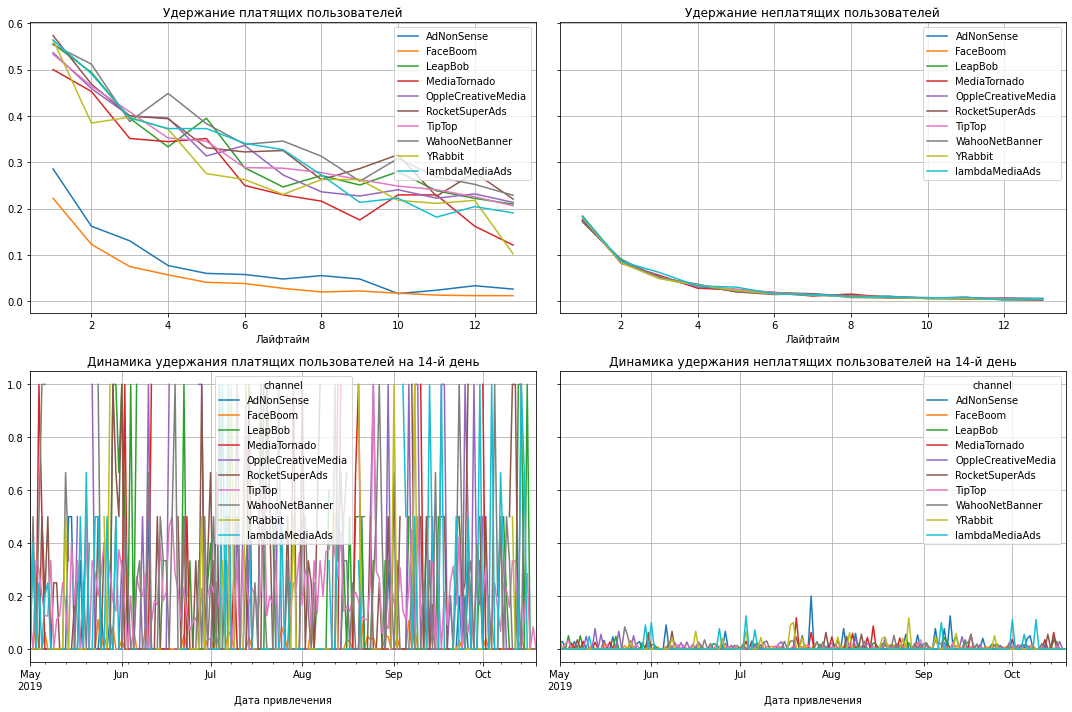

In [51]:
retention_raw,retention,retention_history=get_retention(profiles,visits,observation_date,horizon_date,dimensions=['channel'])
plot_retention(retention,retention_history,horizon_date)

Самое низкое удержание показывают FaceBoom и AdNonSense, к концу второй недели удержание буквально стремится к нулю, имея при этом начальные значения на уровне 20%-30%

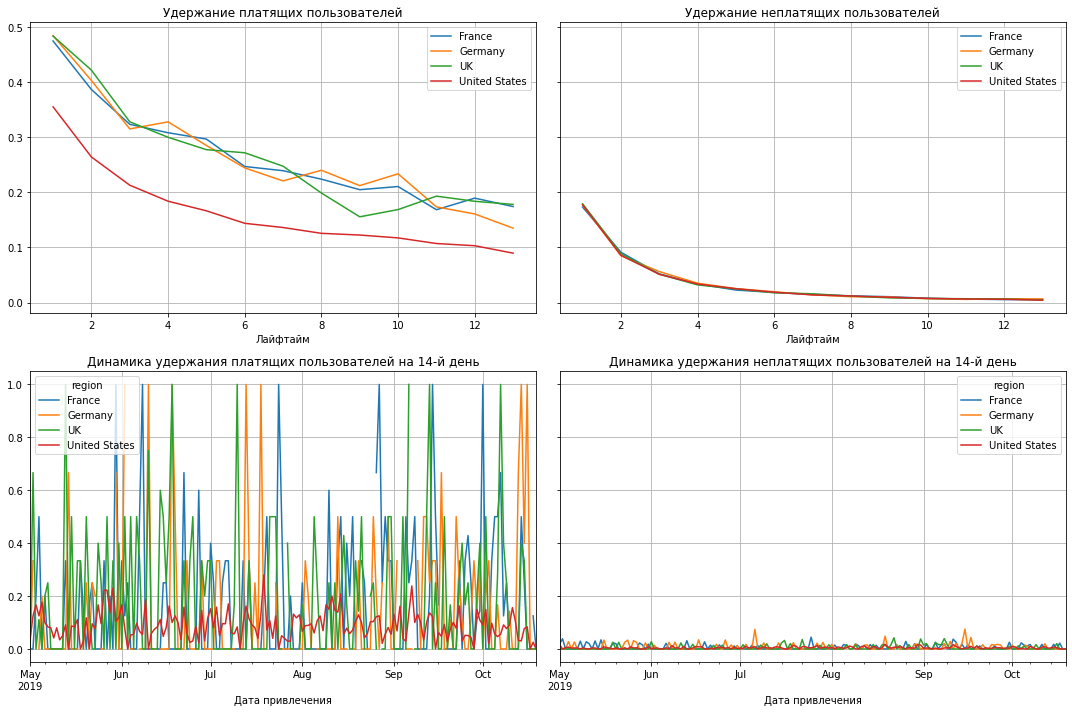

In [52]:
retention_raw,retention,retention_history=get_retention(profiles,visits,observation_date,horizon_date,dimensions=['region'])
plot_retention(retention,retention_history,horizon_date)

Удержание пользователей США является худшим в сравнении со всеми остальными странами. При начальном значении в 35%, к концу второй недели оно составляет менее 10%

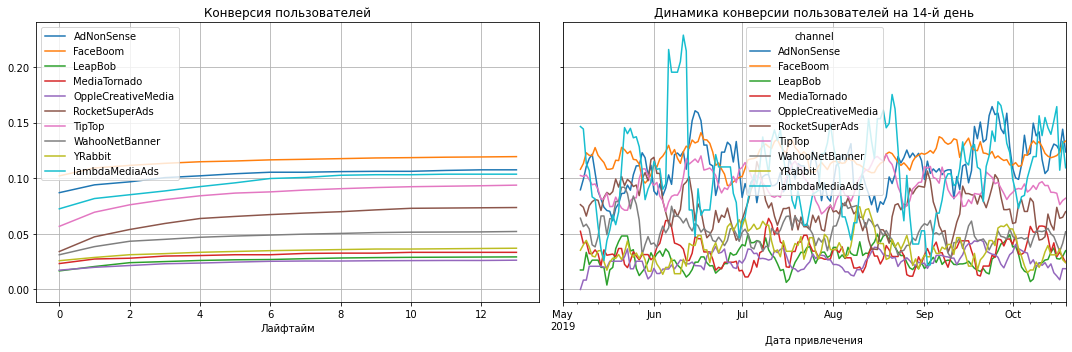

In [53]:
conversion_raw,conversion,conversion_history=get_conversion(profiles,orders,observation_date,horizon_date,dimensions=['channel'])
plot_conversion(conversion,conversion_history,horizon_date)

Самой большой конверсией обладают пользователи FaceBoom, AdNonSense, lambdaMediaAds и TipTop.


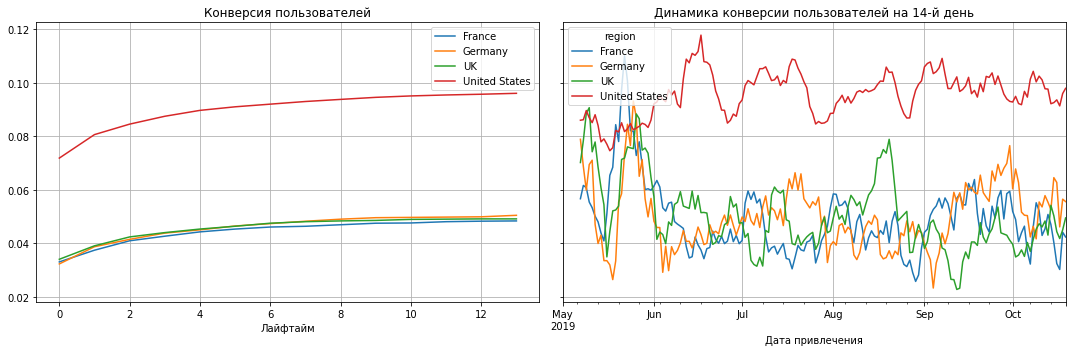

In [54]:
conversion_raw,conversion,conversion_history=get_conversion(profiles,orders,observation_date,horizon_date,dimensions=['region'])
plot_conversion(conversion,conversion_history,horizon_date)

Пользователи США с большим отрывом лидируют в показателе конверсии. Так, уровень конверсии пользователей из США по истечению двух недель состовляет примерно 10%, тогда как в других странах примерно 5%.

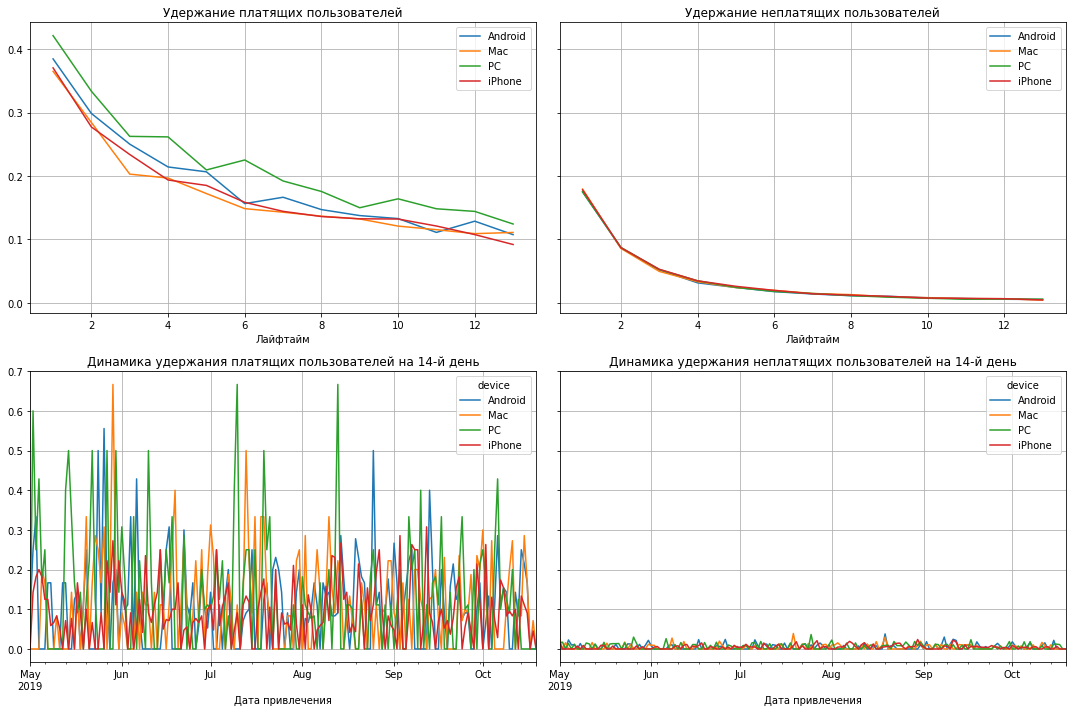

In [55]:
retention_raw,retention,retention_history=get_retention(profiles,visits,observation_date,horizon_date,dimensions=['device'])
plot_retention(retention,retention_history,horizon_date)

Удержание пользователей ПК немного выше остальных устройств, однако, в целом, графики удержания не указывают на то, что тип устройства влияет на окупаемость.

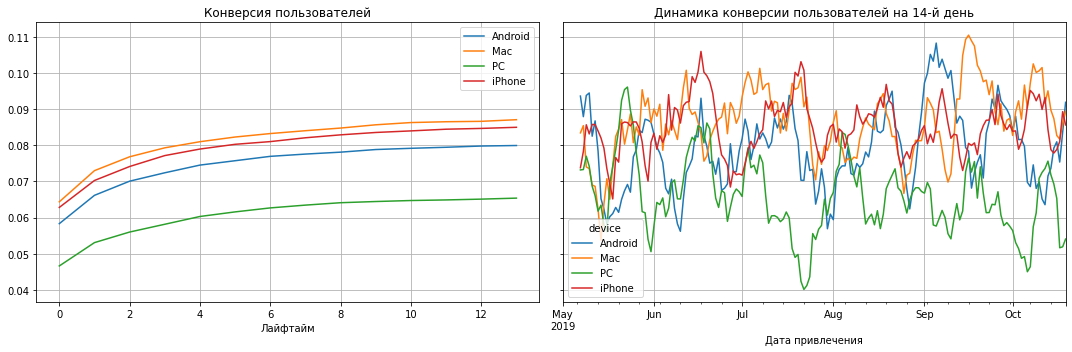

In [56]:
conversion_raw,conversion,conversion_history=get_conversion(profiles,orders,observation_date,horizon_date,dimensions=['device'])
plot_conversion(conversion,conversion_history,horizon_date)

Пользователи Айфона имеют лучшую конверсию(примерно 9%), пользователи ПК - худшую(примерно 6,5%), какие-либо аномалии у пользователей конкретного устройства отсутствуют.

**Вывод**

Выявлена основная проблема: при относительно стабильном уровне LTV, на постоянной основе происходит увеличение расходов по привлечению пользователей(САС), что и привело к тому, что уровень окупаемости с середины июня опустился ниже предельного уровня, и общий уровень окупаемости рекламы доходит лишь до 80%.<br>
Общая конверсия всех пользователей по истечению 14 дней составляет 8%, при этом динамика конверсии относительно стабильная.<br>
Удержание пользователей к концу лайфтайма составляет примерно 10%, динамика также относительно стабильная.<br>
Все кроме устройств ПК не окупаются, при этом динамика ROI на постоянной основе уменьшается, а динамика стоимости привлечения увеличивается. Самыми "дорогими" устройствами являются пользователи Айфона и Мак.<br>
Пользователи США значительно отличаются от пользователей других стран.Так, у данных пользователей самый большой LTV, но при этом самая высокая стоимость привлечения пользователей.Также пользователи США являются единственной когортой, которая не окупается. Уровень окупаемости достигает лишь 60-70%.<br>
Имеется 3 канала привлечения, которые не окупаются: TipTop, FaceBoom и AdNonSense. Эти же каналы лидируют по стоимости одного привлеченного клиента, однако, стоит отметить, что стоимость пользователей TipTop значительно превышает все остальные и постоянно растет. На последний день исследования она составляет 3,5 доллара за клиента, при окупаемости на уровне 50-60%<br>
В разрезе каналов привлечения самое низкое удержание показывают FaceBoom и AdNonSense, к концу второй недели удержание буквально стремится к нулю, имея при этом начальные значения на уровне 20%-30%<br>
В разрезе стран удержание пользователей США является худшим в сравнении со всеми остальными странами. При начальном значении в 35%, к концу второй недели оно составляет менее 10%<br>
Самой большой конверсией обладают пользователи FaceBoom, AdNonSense, lambdaMediaAds и TipTop.
Пользователи США являются лиерами в показателе конверсии. Так, уровень конверсии пользователей из США по истечению двух недель состовляет примерно 10%, тогда как в других странах примерно 5%.<br>
Удержание пользователей ПК немного выше остальных устройств, однако, в целом, графики удержания не указывают на то, что тип устройства влияет на окупаемость.<br>
Пользователи Айфона имеют лучшую конверсию(примерно 9%), пользователи ПК - худшую(примерно 6,5%), какие-либо аномалии у пользователей конкретного устройства отсутствуют.<br>

### Общий вывод


Представленные для анализа данные содержат информацию о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, сведениях об их покупках за этот период, а также статистика рекламных расходов.
В представленных файлах имелись нарушения стиля, а также несоответствие типов данных в столбцах, обозначающих информацию о датах, данные недостатки исправлены.
В результате исследовательского анализа данных получены следующие сведения:
В приложение приходят пользователи из следующих стран: США, Великобритания, Франция, Германия.<br>
Наибольшее количество платящих пользователей из США, на них приходится более 2/3 всех пользователей, оставшееся количество платящих пользователей равномерно распределено между другими странами. Также в США наибольшая доля платящих пользователей 6,9%, что более чем в 1,5 раза больше, чем в каждом из других регионов.<br>
Пользователи приложения предпочитают следующие устройства: Айфон, Мак, Андроид, ПК.<br>
При этом наибольшее количество платящих пользователей предпочитают Айфон - 3382 человека.<br>
Наибольшая доля платящих пользователе приходится на Мак - 6,36%, однако отличие от других устройств незначительое.<br>
Наибольшее число пользоваетелей приходят в приложение самостоятельно(канал - organic) - 56 тыс. человек, однако доля платящих пользователей органического траффика самое маленькое из всех каналов привлечения - 2,06%<br>
Больше всего платящих пользователей привлекают каналы FaceBoom и TipTop 3557 и 1878 человек соответственно.<br>
Рассматривая долю платящих пользователей, можно также выделить крупные источники FaceBoom и TipTop с долями 12,2% и 9,6 % соответственно, также высокой долей платящих пользователей обладают два малоиспользуемых источника - AdNonSence и lambdaMediaAds 11,34% и 10,47% соответственно.<br>

В результате анализа маркетинга компании получены сформулированы следующие выводы:
Общая сумма затрат на рекламу составляет 105497 долларов, при этом основная доля расходов приходится на два канала TipTop - 51.9% и FaceBoom 30.75%
В динамике также прослеживается постоянный рост расходов на два канала TipTop и FaceBoom, при этом расходы на все остальные каналы являются постоянными и значительно отличаются в меньшую сторону.
Самыми дорогими каналами привлечения являются TipTop - 2,8 доллара за каждого нового пользователя и FaceBoom - 1,11 доллара за каждого пользователя.
В результате оценки окупаемости рекламы сформулированы следующие выводы:
ыявлена основная проблема: при относительно стабильном уровне LTV, на постоянной основе происходит увеличение расходов по привлечению пользователей(САС), что и привело к тому, что уровень окупаемости с середины июня опустился ниже предельного уровня, и общий уровень окупаемости рекламы доходит лишь до 80%.<br>
Общая конверсия всех пользователей по истечению 14 дней составляет 8%, при этом динамика конверсии относительно стабильная.<br>
Удержание пользователей к концу лайфтайма составляет примерно 10%, динамика также относительно стабильная.<br>
Все кроме устройств ПК не окупаются, при этом динамика ROI на постоянной основе уменьшается, а динамика стоимости привлечения увеличивается. Самыми "дорогими" устройствами являются пользователи Айфона и Мак.<br>
Пользователи США значительно отличаются от пользователей других стран.Так, у данных пользователей самый большой LTV, но при этом самая высокая стоимость привлечения пользователей.Также пользователи США являются единственной когортой, которая не окупается. Уровень окупаемости достигает лишь 60-70%.<br>
Имеется 3 канала привлечения, которые не окупаются: TipTop, FaceBoom и AdNonSense. Эти же каналы лидируют по стоимости одного привлеченного клиента, однако, стоит отметить, что стоимость пользователей TipTop значительно превышает все остальные и постоянно растет. На последний день исследования она составляет 3,5 доллара за клиента, при окупаемости на уровне 50-60%<br>
В разрезе каналов привлечения самое низкое удержание показывают FaceBoom и AdNonSense, к концу второй недели удержание буквально стремится к нулю, имея при этом начальные значения на уровне 20%-30%<br>
В разрезе стран удержание пользователей США является худшим в сравнении со всеми остальными странами. При начальном значении в 35%, к концу второй недели оно составляет менее 10%<br>
Самой большой конверсией обладают пользователи FaceBoom, AdNonSense, lambdaMediaAds и TipTop.
Пользователи США являются лиерами в показателе конверсии. Так, уровень конверсии пользователей из США по истечению двух недель состовляет примерно 10%, тогда как в других странах примерно 5%.<br>
Удержание пользователей ПК немного выше остальных устройств, однако, в целом, графики удержания не указывают на то, что тип устройства влияет на окупаемость.<br>
Пользователи Айфона имеют лучшую конверсию(примерно 9%), пользователи ПК - худшую(примерно 6,5%), какие-либо аномалии у пользователей конкретного устройства отсутствуют.<br>


Исходя из полученных данных, можно с уверенностью утверждать, что причина убытков компании - это привлечение пользователей по двум каналам TipTop и FaceBoom, которые используются только в США. Несмотря на то, что FaceBoom имеет высокий уровень конверсии, уровень удержания на данном канале низкий. Пользователи уходят раньше, чем окупаются. При этом у пользователей TipTop высокий уровень уровень удержания и LTV, но расходы, которые компания тратит на привлечение по этому каналу не окупаются, так как они растут быстрее. 

**Рекомендации**

Необходимо выяснить причину низкого уровня удержания пользователей из США, которые привлекались из каналов FaceBoom и TipTop, а также из Европейского канала AdNonSense(хоть он и незначителен). Имеется высокий уровень конверсии и низкий уровень удержания, пользователи не возвращаются к приложению. Возможно, имеют место технические неполадки при повторном заказе или же приложение не соответствует требованиям пользователя в долгосрочной перспективе, что вынуждает пользователя отказаться от использования приложения. Необходимо наладить обратную связь с пользователями данных каналов привлечения, чтобы определить потребности клиента, а также вывить причины недовольства приложением.

Необходимо проанализировать расходы на привлечение пользователей через TipTop, несмотря на благоприятные показатели конверсии, уровень затрат превышает доходность - такое использование рекламного бюджета нецелесообразно.

Также необходимо обратить внимание на такие каналы привлечения, как RocketSuperAds и lambdaMediaAds, несмотря на то, что на данные каналы расходуется небольшая часть рекламного бюджета, они обладают высоким уровнем конверсии в платящих пользователей.